# Register and visualize dataset

### Introduction

In this lab you will ingest and transform the customer product reviews dataset. Then you will use AWS data stack services such as AWS Glue and Amazon Athena for ingesting and querying the dataset. Finally you will use AWS Data Wrangler to analyze the dataset and plot some visuals extracting insights.

### Table of Contents

- [1. Ingest and transform the public dataset](#c1w1-1.)
  - [1.1. List the dataset files in the public S3 bucket](#c1w1-1.1.)
    - [Exercise 1](#c1w1-ex-1)
  - [1.2. Copy the data locally to the notebook](#c1w1-1.2.)
  - [1.3. Transform the data](#c1w1-1.3.)
  - [1.4 Write the data to a CSV file](#c1w1-1.4.)
- [2. Register the public dataset for querying and visualizing](#c1w1-2.)
  - [2.1. Register S3 dataset files as a table for querying](#c1w1-2.1.)
    - [Exercise 2](#c1w1-ex-2)
  - [2.2. Create default S3 bucket for Amazon Athena](#c1w1-2.2.)
- [3. Visualize data](#c1w1-3.)
  - [3.1. Preparation for data visualization](#c1w1-3.1.)
  - [3.2. How many reviews per sentiment?](#c1w1-3.2.)
    - [Exercise 3](#c1w1-ex-3)
  - [3.3. Which product categories are highest rated by average sentiment?](#c1w1-3.3.)
  - [3.4. Which product categories have the most reviews?](#c1w1-3.4.)
    - [Exercise 4](#c1w1-ex-4)
  - [3.5. What is the breakdown of sentiments per product category?](#c1w1-3.5.)
  - [3.6. Analyze the distribution of review word counts](#c1w1-3.6.)

Let's install the required modules first.

In [2]:
# please ignore warning messages during the installation
!pip install --disable-pip-version-check -q sagemaker==2.35.0
!pip install --disable-pip-version-check -q pandas==1.1.4
!pip install --disable-pip-version-check -q awswrangler==2.7.0
!pip install --disable-pip-version-check -q numpy==1.18.5
!pip install --disable-pip-version-check -q seaborn==0.11.0
!pip install --disable-pip-version-check -q matplotlib===3.3.3
!pip install -q protobuf==3.20.*

DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sparkmagic 0.20.4 requires nest-asyncio==1.5.5, but you have nest-asyncio 1.5.7 which is incompatible.
DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
ERROR: pip's dependency reso

<a name='c1w1-1.'></a>
# 1. Ingest and transform the public dataset

The dataset [Women's Clothing Reviews](https://www.kaggle.com/nicapotato/womens-ecommerce-clothing-reviews) has been chosen as the main dataset.

It is shared in a public Amazon S3 bucket, and is available as a comma-separated value (CSV) text format:

`s3://dlai-practical-data-science/data/raw/womens_clothing_ecommerce_reviews.csv`

<a name='c1w1-1.1.'></a>
### 1.1. List the dataset files in the public S3 bucket

The [AWS Command Line Interface (CLI)](https://awscli.amazonaws.com/v2/documentation/api/latest/index.html) is a unified tool to manage your AWS services. With just one tool, you can control multiple AWS services from the command line and automate them through scripts. You will use it to list the dataset files.

**View dataset files in CSV format**

```aws s3 ls [bucket_name]``` function lists all objects in the S3 bucket. Let's use it to view the reviews data files in CSV format:

<a name='c1w1-ex-1'></a>
### Exercise 1

View the list of the files available in the public bucket `s3://dlai-practical-data-science/data/raw/`.

**Instructions**:
Use `aws s3 ls [bucket_name]` function. To run the AWS CLI command from the notebook you will need to put an exclamation mark in front of it: `!aws`. You should see the data file `womens_clothing_ecommerce_reviews.csv` in the list.

In [5]:
### BEGIN SOLUTION - DO NOT delete this comment for grading purposes
!aws s3 ls s3://dlai-practical-data-science/data/raw/ # Replace None
### END SOLUTION - DO NOT delete this comment for grading purposes

# EXPECTED OUTPUT
# ... womens_clothing_ecommerce_reviews.csv

2021-04-30 02:21:06    8457214 womens_clothing_ecommerce_reviews.csv


<a name='c1w1-1.2.'></a>
### 1.2. Copy the data locally to the notebook

```aws s3 cp [bucket_name/file_name] [file_name]``` function copies the file from the S3 bucket into the local environment or into another S3 bucket. Let's use it to copy the file with the dataset locally.

In [6]:
!aws s3 cp s3://dlai-practical-data-science/data/raw/womens_clothing_ecommerce_reviews.csv ./womens_clothing_ecommerce_reviews.csv

download: s3://dlai-practical-data-science/data/raw/womens_clothing_ecommerce_reviews.csv to ./womens_clothing_ecommerce_reviews.csv


Now use the Pandas dataframe to load and preview the data.

In [7]:
import pandas as pd
import csv

df = pd.read_csv('./womens_clothing_ecommerce_reviews.csv',
                 index_col=0)

df.shape

(23486, 10)

In [8]:
df

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,847,33,"Cute, crisp shirt",If this product was in petite i would get the...,4,1,2,General,Tops,Blouses
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,I love love love this jumpsuit. it's fun fl...,5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses
...,...,...,...,...,...,...,...,...,...,...
23481,1104,34,Great dress for many occasions,I was very happy to snag this dress at such a ...,5,1,0,General Petite,Dresses,Dresses
23482,862,48,Wish it was made of cotton,It reminds me of maternity clothes. soft stre...,3,1,0,General Petite,Tops,Knits
23483,1104,31,"Cute, but see through",This fit well but the top was very see throug...,3,0,1,General Petite,Dresses,Dresses
23484,1084,28,"Very cute dress, perfect for summer parties an...",I bought this dress for a wedding i have this ...,3,1,2,General,Dresses,Dresses


<a name='c1w1-1.3.'></a>
### 1.3. Transform the data
To simplify the task, you will transform the data into a comma-separated value (CSV) file that contains only a `review_body`, `product_category`, and `sentiment` derived from the original data.

In [9]:
df_transformed = df.rename(columns={'Review Text': 'review_body',
                                    'Rating': 'star_rating',
                                    'Class Name': 'product_category'})
df_transformed.drop(columns=['Clothing ID', 'Age', 'Title', 'Recommended IND', 'Positive Feedback Count', 'Division Name', 'Department Name'],
                    inplace=True)

df_transformed.dropna(inplace=True)

df_transformed.shape

(22628, 3)

Now convert the `star_rating` into the `sentiment` (positive, neutral, negative), which later on will be for the prediction.

In [10]:
def to_sentiment(star_rating):
    if star_rating in {1, 2}: # negative
        return -1 
    if star_rating == 3:      # neutral
        return 0
    if star_rating in {4, 5}: # positive
        return 1

# transform star_rating into the sentiment
df_transformed['sentiment'] = df_transformed['star_rating'].apply(lambda star_rating: 
    to_sentiment(star_rating=star_rating) 
)

# drop the star rating column
df_transformed.drop(columns=['star_rating'],
                    inplace=True)

# remove reviews for product_categories with < 10 reviews
df_transformed = df_transformed.groupby('product_category').filter(lambda reviews : len(reviews) > 10)[['sentiment', 'review_body', 'product_category']]

df_transformed.shape

(22626, 3)

In [11]:
# preview the results
df_transformed

,sentiment,review_body,product_category
0,1,If this product was in petite i would get the...,Blouses
1,1,Love this dress! it's sooo pretty. i happene...,Dresses
2,0,I had such high hopes for this dress and reall...,Dresses
3,1,I love love love this jumpsuit. it's fun fl...,Pants
4,1,This shirt is very flattering to all due to th...,Blouses
...,...,...,...
23481,1,I was very happy to snag this dress at such a ...,Dresses
23482,0,It reminds me of maternity clothes. soft stre...,Knits
23483,0,This fit well but the top was very see throug...,Dresses
23484,0,I bought this dress for a wedding i have this ...,Dresses


<a name='c1w1-1.4.'></a>
### 1.4 Write the data to a CSV file

In [12]:
df_transformed.to_csv('./womens_clothing_ecommerce_reviews_transformed.csv', 
                      index=False)

In [13]:
!head -n 5 ./womens_clothing_ecommerce_reviews_transformed.csv

sentiment,review_body,product_category
1,If this product was in petite  i would get the petite. the regular is a little long on me but a tailor can do a simple fix on that.     fits nicely! i'm 5'4  130lb and pregnant so i bough t medium to grow into.     the tie can be front or back so provides for some nice flexibility on form fitting.,Blouses
1,"Love this dress!  it's sooo pretty.  i happened to find it in a store  and i'm glad i did bc i never would have ordered it online bc it's petite.  i bought a petite and am 5'8"".  i love the length on me- hits just a little below the knee.  would definitely be a true midi on someone who is truly petite.",Dresses
0,I had such high hopes for this dress and really wanted it to work for me. i initially ordered the petite small (my usual size) but i found this to be outrageously small. so small in fact that i could not zip it up! i reordered it in petite medium  which was just ok. overall  the top half was comfortable and fit nicely  but the bott

<a name='c1w1-2.'></a>
# 2. Register the public dataset for querying and visualizing
You will register the public dataset into an S3-backed database table so you can query and visualize our dataset at scale. 

<a name='c1w1-2.1.'></a>
### 2.1. Register S3 dataset files as a table for querying
Let's import required modules.

`boto3` is the AWS SDK for Python to create, configure, and manage AWS services, such as Amazon Elastic Compute Cloud (Amazon EC2) and Amazon Simple Storage Service (Amazon S3). The SDK provides an object-oriented API as well as low-level access to AWS services. 

`sagemaker` is the SageMaker Python SDK which provides several high-level abstractions for working with the Amazon SageMaker.

In [14]:
import boto3
import sagemaker
import pandas as pd
import numpy as np
import botocore

config = botocore.config.Config(user_agent_extra='dlai-pds/c1/w1')

# low-level service client of the boto3 session
sm = boto3.client(service_name='sagemaker', 
                  config=config)

sess = sagemaker.Session(sagemaker_client=sm)                         

bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = sess.boto_region_name
account_id = sess.account_id

print('S3 Bucket: {}'.format(bucket))
print('Region: {}'.format(region))
print('Account ID: {}'.format(account_id))

/opt/conda/lib/python3.7/site-packages/boto3/compat.py:82: PythonDeprecationWarning: Boto3 will no longer support Python 3.7 starting December 13, 2023. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.8 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


S3 Bucket: sagemaker-us-east-1-602848579189
Region: us-east-1
Account ID: <bound method Session.account_id of <sagemaker.session.Session object at 0x7f285adc3690>>


Review the empty bucket which was created automatically for this account.

**Instructions**: 
- open the link
- click on the S3 bucket name `sagemaker-us-east-1-ACCOUNT`
- check that it is empty at this stage

In [15]:
from IPython.core.display import display, HTML

display(HTML('<b>Review <a target="top" href="https://s3.console.aws.amazon.com/s3/home?region={}#">Amazon S3 buckets</a></b>'.format(region)))

Copy the file into the S3 bucket.

In [16]:
!aws s3 cp ./womens_clothing_ecommerce_reviews_transformed.csv s3://$bucket/data/transformed/womens_clothing_ecommerce_reviews_transformed.csv

upload: ./womens_clothing_ecommerce_reviews_transformed.csv to s3://sagemaker-us-east-1-602848579189/data/transformed/womens_clothing_ecommerce_reviews_transformed.csv


Review the bucket with the file we uploaded above.

**Instructions**: 
- open the link
- check that the CSV file is located in the S3 bucket
- check the location directory structure is the same as in the CLI command above
- click on the file name and see the available information about the file (region, size, S3 URI, Amazon Resource Name (ARN))

In [17]:
from IPython.core.display import display, HTML

display(HTML('<b>Review <a target="top" href="https://s3.console.aws.amazon.com/s3/buckets/{}?region={}&prefix=data/transformed/#">Amazon S3 buckets</a></b>'.format(bucket, region)))

**Import AWS Data Wrangler**

[AWS Data Wrangler](https://github.com/awslabs/aws-data-wrangler) is an AWS Professional Service open source python initiative that extends the power of Pandas library to AWS connecting dataframes and AWS data related services (Amazon Redshift, AWS Glue, Amazon Athena, Amazon EMR, Amazon QuickSight, etc).

Built on top of other open-source projects like Pandas, Apache Arrow, Boto3, SQLAlchemy, Psycopg2 and PyMySQL, it offers abstracted functions to execute usual ETL tasks like load/unload data from data lakes, data warehouses and databases.

Review the AWS Data Wrangler documentation: https://aws-data-wrangler.readthedocs.io/en/stable/

In [18]:
import awswrangler as wr

**Create AWS Glue Catalog database**

The data catalog features of **AWS Glue** and the inbuilt integration to Amazon S3 simplify the process of identifying data and deriving the schema definition out of the discovered data. Using AWS Glue crawlers within your data catalog, you can traverse your data stored in Amazon S3 and build out the metadata tables that are defined in your data catalog.

Here you will use `wr.catalog.create_database` function to create a database with the name `dsoaws_deep_learning` ("dsoaws" stands for "Data Science on AWS").

In [19]:
wr.catalog.create_database(
    name='dsoaws_deep_learning',
    exist_ok=True
)

In [20]:
dbs = wr.catalog.get_databases()

for db in dbs:
    print("Database name: " + db['Name'])

Database name: dsoaws_deep_learning


Review the created database in the AWS Glue Catalog.

**Instructions**:
- open the link
- on the left side panel notice that you are in the AWS Glue -> Data Catalog -> Databases
- check that the database `dsoaws_deep_learning` has been created
- click on the name of the database
- click on the `Tables in dsoaws_deep_learning` link to see that there are no tables

In [21]:
from IPython.core.display import display, HTML

display(HTML('<b>Review <a target="top" href="https://console.aws.amazon.com/glue/home?region={}#catalog:tab=databases">AWS Glue Databases</a></b>'.format(region)))

**Register CSV data with AWS Glue Catalog**

<a name='c1w1-ex-2'></a>
### Exercise 2

Register CSV data with AWS Glue Catalog.

**Instructions**:
Use ```wr.catalog.create_csv_table``` function with the following parameters
```python
res = wr.catalog.create_csv_table(
    database='...', # AWS Glue Catalog database name
    path='s3://{}/data/transformed/'.format(bucket), # S3 object path for the data
    table='reviews', # registered table name
    columns_types={
        'sentiment': 'int',        
        'review_body': 'string',
        'product_category': 'string'      
    },
    mode='overwrite',
    skip_header_line_count=1,
    sep=','    
)
```

In [22]:
wr.catalog.create_csv_table(
    ### BEGIN SOLUTION - DO NOT delete this comment for grading purposes
    database='dsoaws_deep_learning', # Replace None
    ### END SOLUTION - DO NOT delete this comment for grading purposes
    path='s3://{}/data/transformed/'.format(bucket), 
    table="reviews",    
    columns_types={
        'sentiment': 'int',        
        'review_body': 'string',
        'product_category': 'string'      
    },
    mode='overwrite',
    skip_header_line_count=1,
    sep=','
)

Review the registered table in the AWS Glue Catalog.

**Instructions**:
- open the link
- on the left side panel notice that you are in the AWS Glue -> Data Catalog -> Databases -> Tables
- check that you can see the table `reviews` from the database `dsoaws_deep_learning` in the list
- click on the name of the table
- explore the available information about the table (name, database, classification, location, schema etc.)

In [23]:
from IPython.core.display import display, HTML

display(HTML('<b>Review <a target="top" href="https://console.aws.amazon.com/glue/home?region={}#">AWS Glue Catalog</a></b>'.format(region)))

Review the table shape:

In [24]:
table = wr.catalog.table(database='dsoaws_deep_learning',
                         table='reviews')
table

,Column Name,Type,Partition,Comment
0,sentiment,int,False,
1,review_body,string,False,
2,product_category,string,False,


<a name='c1w1-2.2.'></a>
### 2.2. Create default S3 bucket for Amazon Athena

Amazon Athena requires this S3 bucket to store temporary query results and improve performance of subsequent queries.

The contents of this bucket are mostly binary and human-unreadable. 

In [25]:
# S3 bucket name
wr.athena.create_athena_bucket()

# EXPECTED OUTPUT
# 's3://aws-athena-query-results-ACCOUNT-REGION/'

's3://aws-athena-query-results-602848579189-us-east-1/'

<a name='c1w1-3.'></a>
# 3. Visualize data

**Reviews dataset - column descriptions**

- `sentiment`: The review's sentiment (-1, 0, 1).
- `product_category`: Broad product category that can be used to group reviews (in this case digital videos).
- `review_body`: The text of the review.

<a name='c1w1-3.1.'></a>
### 3.1. Preparation for data visualization

**Imports**

In [26]:
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

**Settings**

Set AWS Glue database and table name.

In [27]:
# Do not change the database and table names - they are used for grading purposes!
database_name = 'dsoaws_deep_learning'
table_name = 'reviews'

Set seaborn parameters. You can review seaborn documentation following the [link](https://seaborn.pydata.org/index.html).

In [28]:
sns.set_style = 'seaborn-whitegrid'

sns.set(rc={"font.style":"normal",
            "axes.facecolor":"white",
            'grid.color': '.8',
            'grid.linestyle': '-',
            "figure.facecolor":"white",
            "figure.titlesize":20,
            "text.color":"black",
            "xtick.color":"black",
            "ytick.color":"black",
            "axes.labelcolor":"black",
            "axes.grid":True,
            'axes.labelsize':10,
            'xtick.labelsize':10,
            'font.size':10,
            'ytick.labelsize':10})

Helper code to display values on barplots:

**Run SQL queries using Amazon Athena**

**Amazon Athena** lets you query data in Amazon S3 using a standard SQL interface. It reflects the databases and tables in the AWS Glue Catalog. You can create interactive queries and perform any data manipulations required for further downstream processing.

Standard SQL query can be saved as a string and then passed as a parameter into the Athena query. Run the following cells as an example to count the total number of reviews by sentiment. The SQL query here will take the following form:

```sql
SELECT column_name, COUNT(column_name) as new_column_name
FROM table_name
GROUP BY column_name
ORDER BY column_name
```

If you are not familiar with the SQL query statements, you can review some tutorials following the [link](https://www.w3schools.com/sql/default.asp).

<a name='c1w1-3.2.'></a>
### 3.2. How many reviews per sentiment?

Set the SQL statement to find the count of sentiments:

In [29]:
statement_count_by_sentiment = """
SELECT sentiment, COUNT(sentiment) AS count_sentiment
FROM reviews
GROUP BY sentiment
ORDER BY sentiment
"""

print(statement_count_by_sentiment)


SELECT sentiment, COUNT(sentiment) AS count_sentiment
FROM reviews
GROUP BY sentiment
ORDER BY sentiment



Query data in Amazon Athena database cluster using the prepared SQL statement:

In [30]:
df_count_by_sentiment = wr.athena.read_sql_query(
    sql=statement_count_by_sentiment,
    database=database_name
)

print(df_count_by_sentiment)

   sentiment  count_sentiment
0         -1             2370
1          0             2823
2          1            17433


Preview the results of the query:

<AxesSubplot:xlabel='sentiment'>

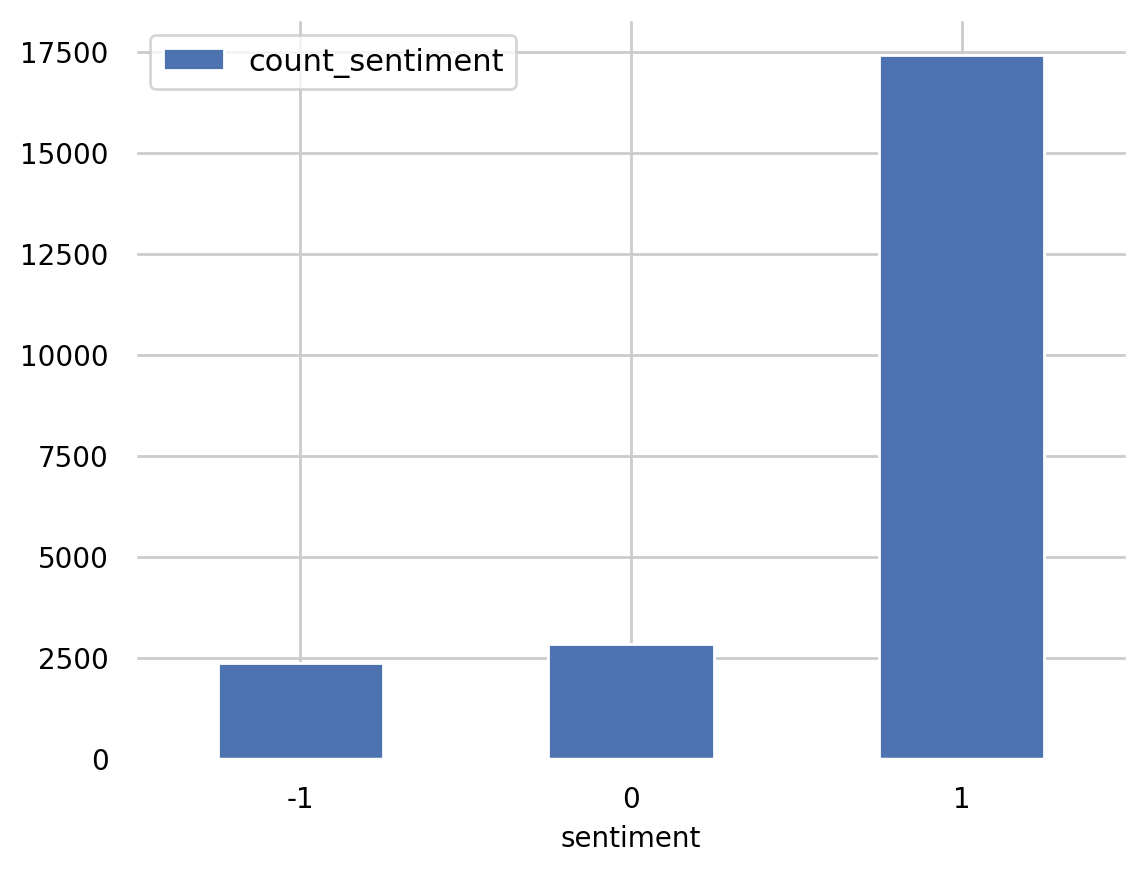

In [31]:
df_count_by_sentiment.plot(kind='bar', x='sentiment', y='count_sentiment', rot=0)

<a name='c1w1-ex-3'></a>
### Exercise 3

Use Amazon Athena query with the standard SQL statement passed as a parameter, to calculate the total number of reviews per `product_category` in the table ```reviews```.

**Instructions**: Pass the SQL statement of the form

```sql
SELECT category_column, COUNT(column_name) AS new_column_name
FROM table_name
GROUP BY category_column
ORDER BY new_column_name DESC
```

as a triple quote string into the variable `statement_count_by_category`. Please use the column `sentiment` in the `COUNT` function and give it a new name `count_sentiment`.

In [32]:
# Replace all None
### BEGIN SOLUTION - DO NOT delete this comment for grading purposes
statement_count_by_category = """
SELECT product_category, COUNT(sentiment) AS count_sentiment
FROM reviews
GROUP BY product_category
ORDER BY count_sentiment DESC
"""

### END SOLUTION - DO NOT delete this comment for grading purposes
print(statement_count_by_category)


SELECT product_category, COUNT(sentiment) AS count_sentiment
FROM reviews
GROUP BY product_category
ORDER BY count_sentiment DESC



Query data in Amazon Athena database passing the prepared SQL statement:

In [38]:
%%time
df_count_by_category = wr.athena.read_sql_query(
    sql=statement_count_by_category,
    database=database_name
)

df_count_by_category

# EXPECTED OUTPUT
# Dresses: 6145
# Knits: 4626
# Blouses: 2983
# Sweaters: 1380
# Pants: 1350
# ...

CPU times: user 503 ms, sys: 34 ms, total: 537 ms
Wall time: 3.17 s


,product_category,count_sentiment
0,Dresses,6145
1,Knits,4626
2,Blouses,2983
3,Sweaters,1380
4,Pants,1350
5,Jeans,1104
6,Fine gauge,1059
7,Skirts,903
8,Jackets,683
9,Lounge,669


<a name='c1w1-3.3.'></a>
### 3.3. Which product categories are highest rated by average sentiment?

Set the SQL statement to find the average sentiment per product category, showing the results in the descending order:

In [39]:
statement_avg_by_category = """
SELECT product_category, AVG(sentiment) AS avg_sentiment
FROM {} 
GROUP BY product_category 
ORDER BY avg_sentiment DESC
""".format(table_name)

print(statement_avg_by_category)


SELECT product_category, AVG(sentiment) AS avg_sentiment
FROM reviews 
GROUP BY product_category 
ORDER BY avg_sentiment DESC



Query data in Amazon Athena database passing the prepared SQL statement:

In [41]:
%%time
df_avg_by_category = wr.athena.read_sql_query(
    sql=statement_avg_by_category,
    database=database_name
)

df_avg_by_category

CPU times: user 364 ms, sys: 20.4 ms, total: 384 ms
Wall time: 3.5 s


,product_category,avg_sentiment
0,Layering,0.780303
1,Jeans,0.746377
2,Lounge,0.745889
3,Sleep,0.710280
4,Shorts,0.707237
5,Pants,0.705185
6,Intimates,0.700680
7,Jackets,0.699854
8,Skirts,0.696567
9,Legwear,0.696203


Preview the query results in the temporary S3 bucket:  `s3://aws-athena-query-results-ACCOUNT-REGION/`

**Instructions**: 
- open the link
- check the name of the S3 bucket
- briefly check the content of it

In [42]:
from IPython.core.display import display, HTML

display(HTML('<b>Review <a target="top" href="https://s3.console.aws.amazon.com/s3/buckets/aws-athena-query-results-{}-{}?region={}">Amazon S3 buckets</a></b>'.format(account_id, region, region)))

Preview the results of the query:

In [43]:
df_avg_by_category

,product_category,avg_sentiment
0,Layering,0.780303
1,Jeans,0.746377
2,Lounge,0.745889
3,Sleep,0.710280
4,Shorts,0.707237
5,Pants,0.705185
6,Intimates,0.700680
7,Jackets,0.699854
8,Skirts,0.696567
9,Legwear,0.696203


**Visualization**

In [44]:
def show_values_barplot(axs, space):
    def _show_on_plot(ax):
        for p in ax.patches:
            _x = p.get_x() + p.get_width() + float(space)
            _y = p.get_y() + p.get_height()
            value = round(float(p.get_width()),2)
            ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_plot(ax)
    else:
        _show_on_plot(axs)

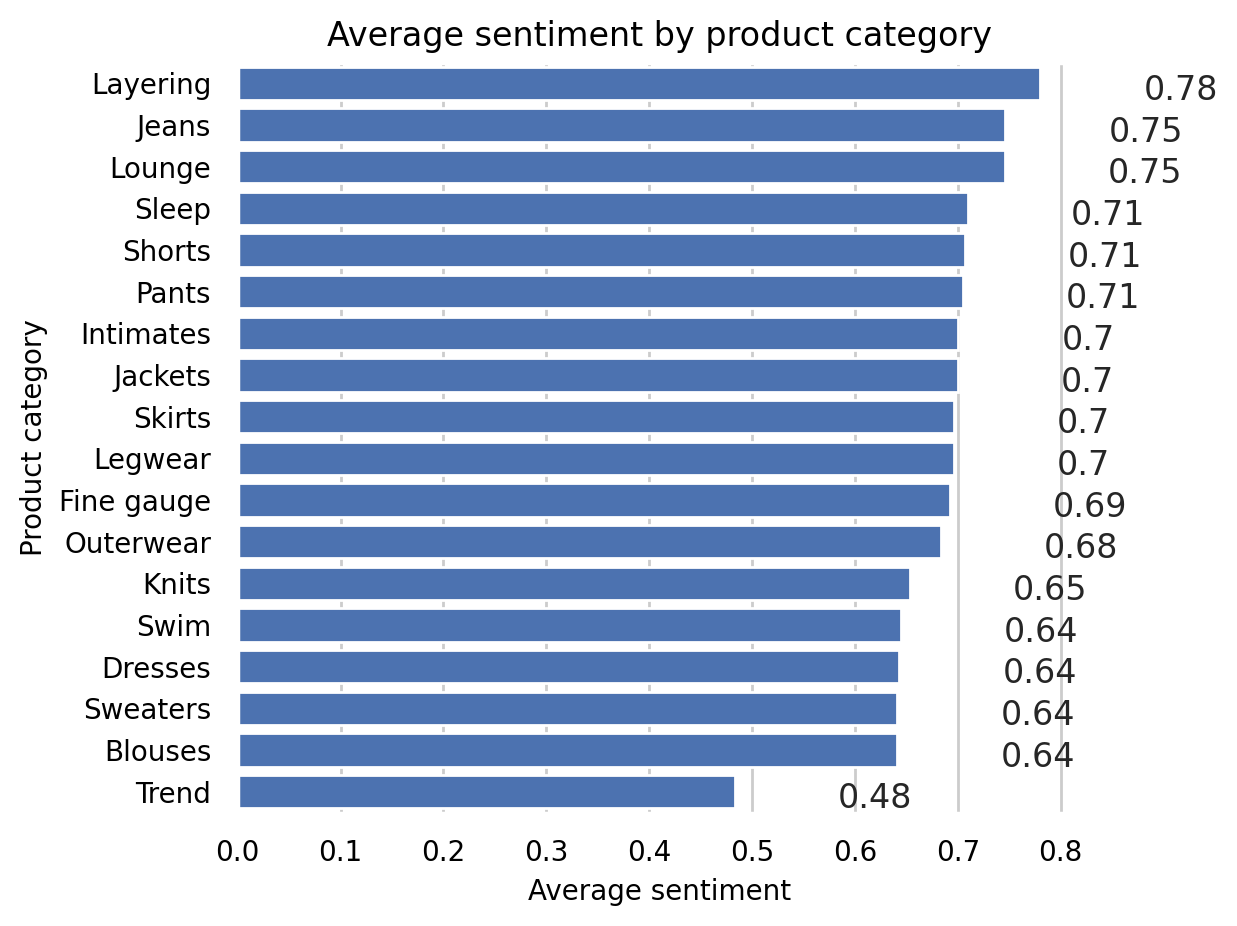

In [45]:
# Create plot
barplot = sns.barplot(
    data = df_avg_by_category, 
    y='product_category',
    x='avg_sentiment', 
    color="b", 
    saturation=1
)

# Set the size of the figure
sns.set(rc={'figure.figsize':(15.0, 10.0)})
    
# Set title and x-axis ticks 
plt.title('Average sentiment by product category')
#plt.xticks([-1, 0, 1], ['Negative', 'Neutral', 'Positive'])

# Helper code to show actual values afters bars 
show_values_barplot(barplot, 0.1)

plt.xlabel("Average sentiment")
plt.ylabel("Product category")

plt.tight_layout()
# Do not change the figure name - it is used for grading purposes!
plt.savefig('avg_sentiment_per_category.png', dpi=300)

# Show graphic
plt.show(barplot)

In [46]:
# Upload image to S3 bucket
sess.upload_data(path='avg_sentiment_per_category.png', bucket=bucket, key_prefix="images")

's3://sagemaker-us-east-1-602848579189/images/avg_sentiment_per_category.png'

Review the bucket on the account.

**Instructions**: 
- open the link
- click on the S3 bucket name `sagemaker-us-east-1-ACCOUNT`
- open the images folder
- check the existence of the image `avg_sentiment_per_category.png`
- if you click on the image name, you can see the information about the image file. You can also download the file with the command on the top right Object Actions -> Download / Download as
<img src="images/download_image_file.png" width="100%">

In [47]:
from IPython.core.display import display, HTML

display(HTML('<b>Review <a target="top" href="https://s3.console.aws.amazon.com/s3/home?region={}">Amazon S3 buckets</a></b>'.format(region)))

<a name='c1w1-3.4.'></a>
### 3.4. Which product categories have the most reviews?

Set the SQL statement to find the count of sentiment per product category, showing the results in the descending order:

In [48]:
statement_count_by_category_desc = """
SELECT product_category, COUNT(*) AS count_reviews 
FROM {}
GROUP BY product_category 
ORDER BY count_reviews DESC
""".format(table_name)

print(statement_count_by_category_desc)


SELECT product_category, COUNT(*) AS count_reviews 
FROM reviews
GROUP BY product_category 
ORDER BY count_reviews DESC



Query data in Amazon Athena database passing the prepared SQL statement:

In [49]:
%%time
df_count_by_category_desc = wr.athena.read_sql_query(
    sql=statement_count_by_category_desc,
    database=database_name
)

CPU times: user 520 ms, sys: 29 ms, total: 549 ms
Wall time: 3.23 s


Store maximum number of sentiment for the visualization plot:

In [50]:
max_sentiment = df_count_by_category_desc['count_reviews'].max()
print('Highest number of reviews (in a single category): {}'.format(max_sentiment))

Highest number of reviews (in a single category): 6145


**Visualization**

<a name='c1w1-ex-4'></a>
### Exercise 4

Use `barplot` function to plot number of reviews per product category.

**Instructions**: Use the `barplot` chart example in the previous section, passing the newly defined dataframe `df_count_by_category_desc` with the count of reviews. Here, please put the `product_category` column into the `y` argument.

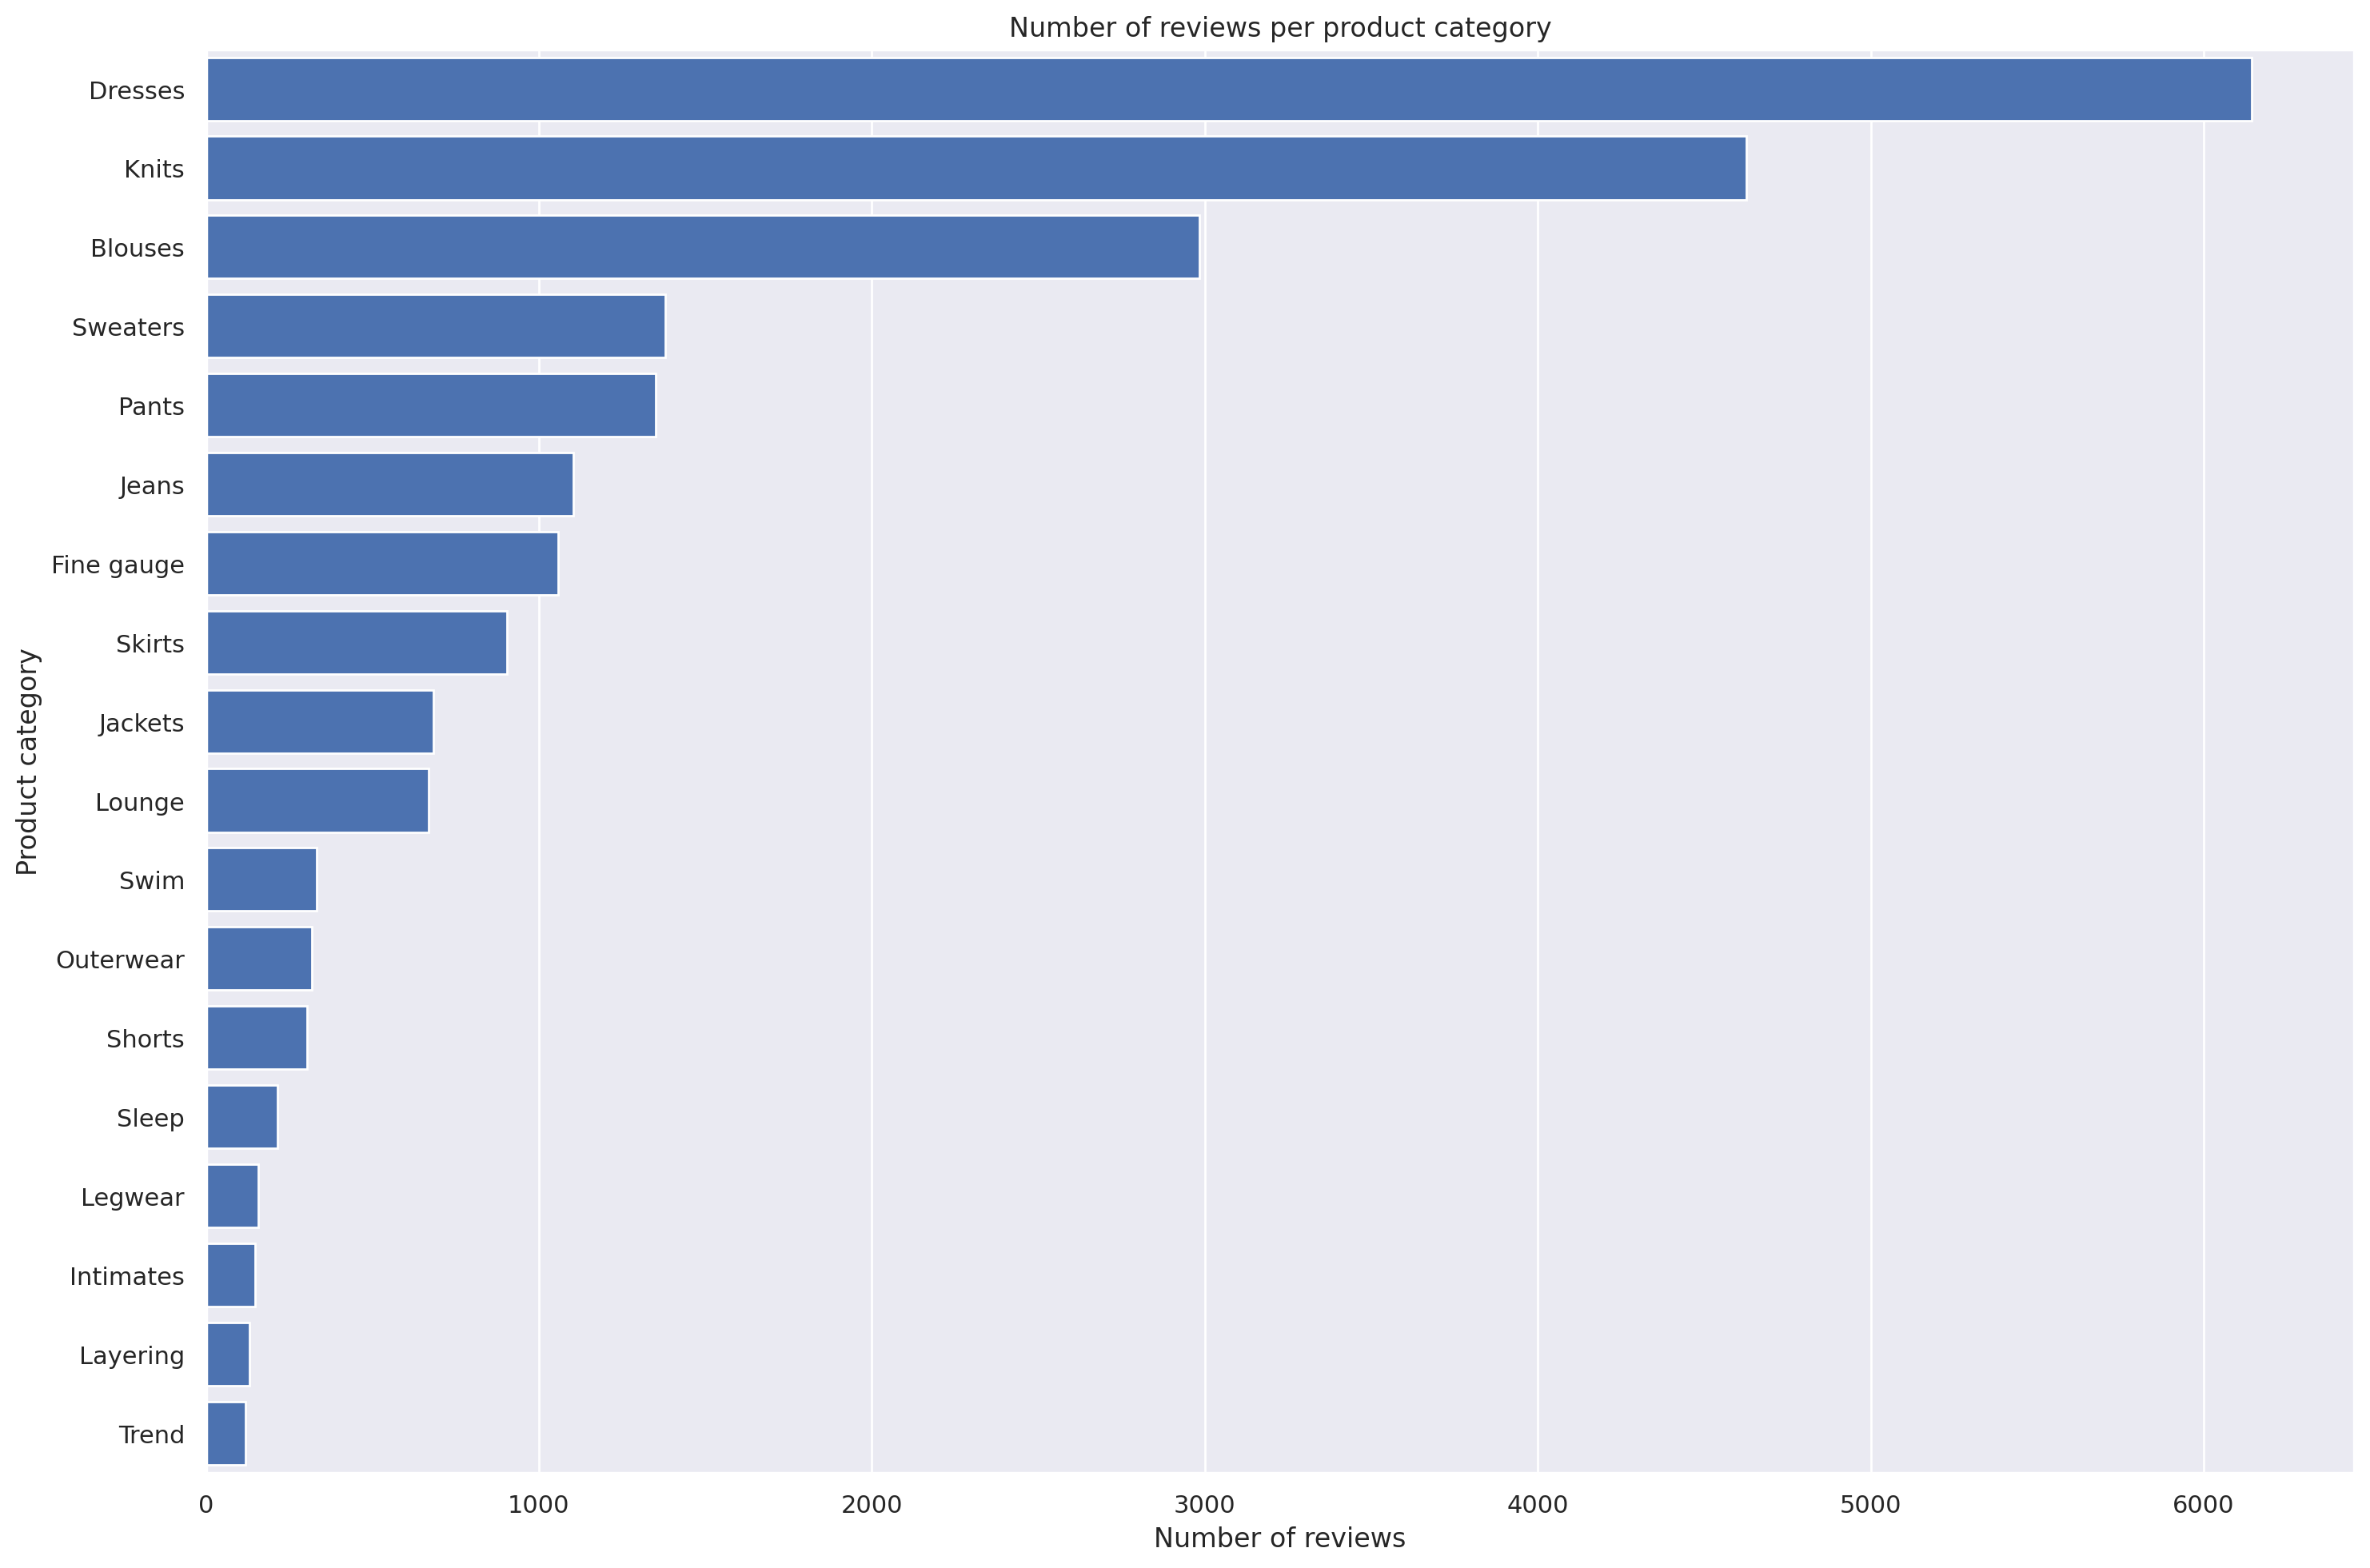

In [51]:
# Create seaborn barplot
barplot = sns.barplot(
    ### BEGIN SOLUTION - DO NOT delete this comment for grading purposes
    data=df_count_by_category, # Replace None
    y='product_category', # Replace None
    x='count_sentiment', # Replace None
    ### END SOLUTION - DO NOT delete this comment for grading purposes
    color="b",
    saturation=1
)

# Set the size of the figure
sns.set(rc={'figure.figsize':(15.0, 10.0)})
    
# Set title
plt.title("Number of reviews per product category")
plt.xlabel("Number of reviews")
plt.ylabel("Product category")

plt.tight_layout()

# Do not change the figure name - it is used for grading purposes!
plt.savefig('num_reviews_per_category.png', dpi=300)

# Show the barplot
plt.show(barplot)

In [52]:
# Upload image to S3 bucket
sess.upload_data(path='num_reviews_per_category.png', bucket=bucket, key_prefix="images")

's3://sagemaker-us-east-1-602848579189/images/num_reviews_per_category.png'

<a name='c1w1-3.5.'></a>
### 3.5. What is the breakdown of sentiments per product category?

Set the SQL statement to find the count of sentiment per product category and sentiment:

In [53]:
statement_count_by_category_and_sentiment = """
SELECT product_category,
         sentiment,
         COUNT(*) AS count_reviews
FROM {}
GROUP BY  product_category, sentiment
ORDER BY  product_category ASC, sentiment DESC, count_reviews
""".format(table_name)

print(statement_count_by_category_and_sentiment)


SELECT product_category,
         sentiment,
         COUNT(*) AS count_reviews
FROM reviews
GROUP BY  product_category, sentiment
ORDER BY  product_category ASC, sentiment DESC, count_reviews



Query data in Amazon Athena database passing the prepared SQL statement:

In [54]:
%%time
df_count_by_category_and_sentiment = wr.athena.read_sql_query(
    sql=statement_count_by_category_and_sentiment,
    database=database_name
)

CPU times: user 325 ms, sys: 11.8 ms, total: 337 ms
Wall time: 2.8 s


Prepare for stacked percentage horizontal bar plot showing proportion of sentiments per product category.

In [55]:
# Create grouped dataframes by category and by sentiment
grouped_category = df_count_by_category_and_sentiment.groupby('product_category')
grouped_star = df_count_by_category_and_sentiment.groupby('sentiment')

# Create sum of sentiments per star sentiment
df_sum = df_count_by_category_and_sentiment.groupby(['sentiment']).sum()

# Calculate total number of sentiments
total = df_sum['count_reviews'].sum()
print('Total number of reviews: {}'.format(total))

Total number of reviews: 22626


Create dictionary of product categories and array of star rating distribution per category.

In [56]:
distribution = {}
count_reviews_per_star = []
i=0

for category, sentiments in grouped_category:
    count_reviews_per_star = []
    for star in sentiments['sentiment']:
        count_reviews_per_star.append(sentiments.at[i, 'count_reviews'])
        i=i+1;
    distribution[category] = count_reviews_per_star

Build array per star across all categories.

In [57]:
distribution

{'Blouses': [2256, 384, 343],
 'Dresses': [4634, 830, 681],
 'Fine gauge': [837, 118, 104],
 'Intimates': [117, 16, 14],
 'Jackets': [550, 61, 72],
 'Jeans': [909, 110, 85],
 'Knits': [3523, 605, 498],
 'Layering': [113, 9, 10],
 'Legwear': [126, 16, 16],
 'Lounge': [545, 78, 46],
 'Outerwear': [254, 29, 36],
 'Pants': [1074, 154, 122],
 'Shorts': [240, 39, 25],
 'Skirts': [714, 104, 85],
 'Sleep': [175, 16, 23],
 'Sweaters': [1036, 193, 151],
 'Swim': [252, 42, 38],
 'Trend': [78, 19, 21]}

In [ ]:
df_distribution_pct = pd.DataFrame(distribution).transpose().apply(
    lambda num_sentiments: num_sentiments/sum(num_sentiments)*100, axis=1
)
df_distribution_pct.columns=['1', '0', '-1']
df_distribution_pct

**Visualization**

Plot the distributions of sentiments per product category.

In [ ]:
categories = df_distribution_pct.index

# Plot bars
plt.figure(figsize=(10,5))

df_distribution_pct.plot(kind="barh", 
                         stacked=True, 
                         edgecolor='white',
                         width=1.0,
                         color=['green', 
                                'orange', 
                                'blue'])

plt.title("Distribution of reviews per sentiment per category", 
          fontsize='16')

plt.legend(bbox_to_anchor=(1.04,1), 
           loc="upper left",
           labels=['Positive', 
                   'Neutral', 
                   'Negative'])

plt.xlabel("% Breakdown of sentiments", fontsize='14')
plt.gca().invert_yaxis()
plt.tight_layout()

# Do not change the figure name - it is used for grading purposes!
plt.savefig('distribution_sentiment_per_category.png', dpi=300)
plt.show()

In [ ]:
# Upload image to S3 bucket
sess.upload_data(path='distribution_sentiment_per_category.png', bucket=bucket, key_prefix="images")

<a name='c1w1-3.6.'></a>
### 3.6. Analyze the distribution of review word counts

Set the SQL statement to count the number of the words in each of the reviews:

In [ ]:
statement_num_words = """
    SELECT CARDINALITY(SPLIT(review_body, ' ')) as num_words
    FROM {}
""".format(table_name)

print(statement_num_words)

Query data in Amazon Athena database passing the SQL statement:

In [ ]:
%%time
df_num_words = wr.athena.read_sql_query(
    sql=statement_num_words,
    database=database_name
)

Print out and analyse some descriptive statistics: 

In [ ]:
summary = df_num_words["num_words"].describe(percentiles=[0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 1.00])
summary

Plot the distribution of the words number per review:

In [ ]:
df_num_words["num_words"].plot.hist(xticks=[0, 16, 32, 64, 128, 256], bins=100, range=[0, 256]).axvline(
    x=summary["100%"], c="red"
)

plt.xlabel("Words number", fontsize='14')
plt.ylabel("Frequency", fontsize='14')
plt.savefig('distribution_num_words_per_review.png', dpi=300)
plt.show()

In [ ]:
# Upload image to S3 bucket
sess.upload_data(path='distribution_num_words_per_review.png', bucket=bucket, key_prefix="images")

Upload the notebook into S3 bucket for grading purposes.

**Note**: you may need to click on "Save" button before the upload.

In [ ]:
!aws s3 cp ./C1_W1_Assignment.ipynb s3://$bucket/C1_W1_Assignment_Learner.ipynb

Please go to the main lab window and click on `Submit` button (see the `Finish the lab` section of the instructions).